# Probabilistic Bayesian Neural Network

```bash
pip install tensorflow-probability tensorflow-datasets
```

In [18]:
(X_tr, y_tr), (X_te, y_te) = tf.keras.datasets.boston_housing.load_data(
    path='boston_housing.npz', 
    test_split=0.2, 
    seed=37
)

X_tr.shape, y_tr.shape, X_te.shape, y_te.shape

((404, 13), (404,), (102, 13), (102,))

In [28]:
import tensorflow as tf

# inc_dataset = tf.data.Dataset.range(100)
# dec_dataset = tf.data.Dataset.range(0, -100, -1)
# dataset = tf.data.Dataset.zip((inc_dataset, dec_dataset))
# batched_dataset = dataset.batch(4)

tf.data.Dataset.zip((
    tf.data.Dataset.from_tensors(X_tr),
    tf.data.Dataset.from_tensors(y_tr)
)).batch(4)


<BatchDataset element_spec=(TensorSpec(shape=(None, 404, 13), dtype=tf.float64, name=None), TensorSpec(shape=(None, 404), dtype=tf.float64, name=None))>

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds

def get_data(dataset_size=4898, batch_size=256):
    train_size = int(dataset_size * 0.85)
    dataset = tfds.load(name='wine_quality', as_supervised=True, split='train') \
        .map(lambda x, y: (x, tf.cast(y, tf.float32))) \
        .prefetch(buffer_size=dataset_size) \
        .cache()
    
    X_tr = dataset.take(train_size).shuffle(buffer_size=train_size).batch(batch_size)
    X_te = dataset.skip(train_size).batch(batch_size)

    return X_tr, X_te

X_tr, X_te = get_data()

2022-10-12 16:01:37.077341: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-12 16:01:37.181607: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-12 16:01:37.666145: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.7/lib64
2022-10-12 16:01:37.666208: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: can

In [15]:
list(X_tr.element_spec[0].keys())

['alcohol',
 'chlorides',
 'citric acid',
 'density',
 'fixed acidity',
 'free sulfur dioxide',
 'pH',
 'residual sugar',
 'sulphates',
 'total sulfur dioxide',
 'volatile acidity']

In [17]:
type(X_tr)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [16]:
X_tr

<BatchDataset element_spec=({'alcohol': TensorSpec(shape=(None,), dtype=tf.float32, name=None), 'chlorides': TensorSpec(shape=(None,), dtype=tf.float32, name=None), 'citric acid': TensorSpec(shape=(None,), dtype=tf.float32, name=None), 'density': TensorSpec(shape=(None,), dtype=tf.float32, name=None), 'fixed acidity': TensorSpec(shape=(None,), dtype=tf.float32, name=None), 'free sulfur dioxide': TensorSpec(shape=(None,), dtype=tf.float32, name=None), 'pH': TensorSpec(shape=(None,), dtype=tf.float32, name=None), 'residual sugar': TensorSpec(shape=(None,), dtype=tf.float32, name=None), 'sulphates': TensorSpec(shape=(None,), dtype=tf.float64, name=None), 'total sulfur dioxide': TensorSpec(shape=(None,), dtype=tf.float32, name=None), 'volatile acidity': TensorSpec(shape=(None,), dtype=tf.float32, name=None)}, TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [11]:
dir(X_tr)

['_GeneratorState',
 '__abstractmethods__',
 '__bool__',
 '__class__',
 '__class_getitem__',
 '__debug_string__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__nonzero__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__tf_tracing_type__',
 '__weakref__',
 '_abc_impl',
 '_add_trackable_child',
 '_add_variable_with_custom_getter',
 '_apply_debug_options',
 '_as_serialized_graph',
 '_batch_size',
 '_checkpoint_dependencies',
 '_common_args',
 '_consumers',
 '_convert_variables_to_tensors',
 '_deferred_dependencies',
 '_deserialization_dependencies',
 '_deserialize_from_proto',
 '_drop_remainder',
 '_export_to_saved_model_graph',
 '_flat_shapes',
 '_flat_structure',
 '_flat_types',
 '_functions',
 '_g

In [3]:
import numpy as np

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_probability as tfp

FEATURE_NAMES = [
    'CRIM',
    'ZN',
    'INDUS',
    'CHAS',
    'NOX',
    'RM',
    'AGE',
    'DIS',
    'RAD',
    'TAX',
    'PTRATIO',
    'B',
    'LSTAT'
]

FEATURE_NAMES = list(X_tr.element_spec[0].keys())

def get_inputs():
    get_input = lambda feature: layers.Input(name=feature, shape=(1,), dtype=tf.float32)
    return  {feature_name: get_input(feature_name) for feature_name in FEATURE_NAMES}

def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    prior_model = keras.Sequential(
        [
            tfp.layers.DistributionLambda(
                lambda t: tfp.distributions.MultivariateNormalDiag(
                    loc=tf.zeros(n), scale_diag=tf.ones(n)
                )
            )
        ]
    )
    return prior_model

def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    posterior_model = keras.Sequential(
        [
            tfp.layers.VariableLayer(
                tfp.layers.MultivariateNormalTriL.params_size(n), dtype=dtype
            ),
            tfp.layers.MultivariateNormalTriL(n),
        ]
    )
    return posterior_model

def get_model(train_size, hidden_units=[8, 8]):
    inputs = get_inputs()
    features = keras.layers.concatenate(list(inputs.values()))
    features = layers.BatchNormalization()(features)

    for units in hidden_units:
        features = tfp.layers.DenseVariational(
            units=units,
            make_prior_fn=prior,
            make_posterior_fn=posterior,
            kl_weight=1 / train_size,
            activation='sigmoid',
        )(features)

    distribution_params = layers.Dense(units=2)(features)
    outputs = tfp.layers.IndependentNormal(1)(distribution_params)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

model = get_model(100)

Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.


Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.


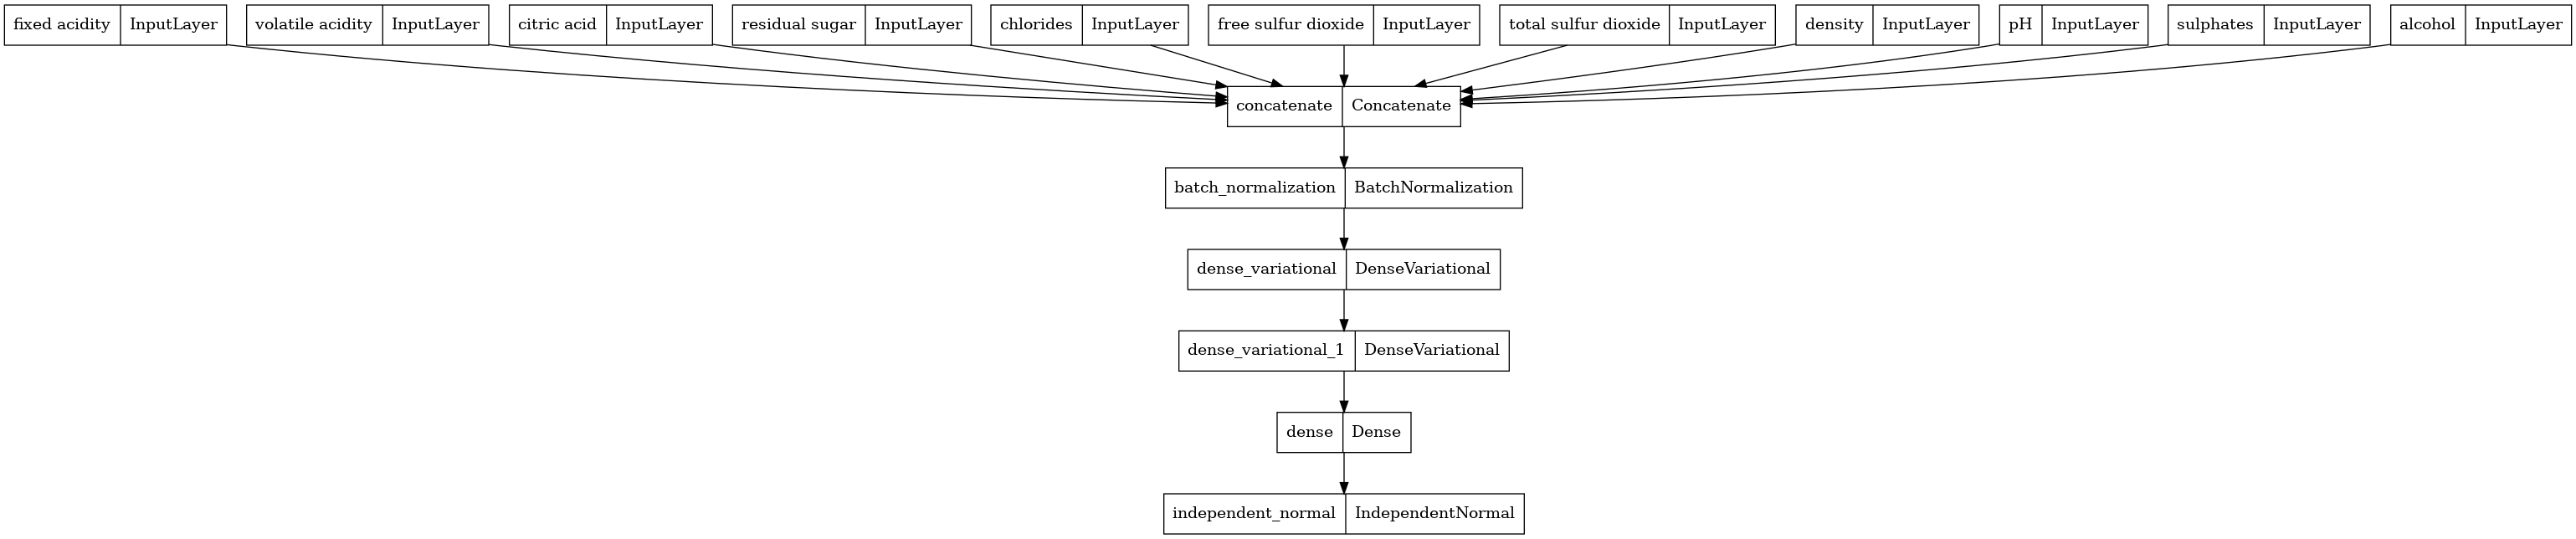

In [4]:
keras.utils.plot_model(model)

In [5]:
def negative_loglikelihood(targets, estimated_distribution):
    return -estimated_distribution.log_prob(targets)

model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
    loss=negative_loglikelihood,
    metrics=[keras.metrics.RootMeanSquaredError()],
)

In [6]:
model.fit(x=X_tr, validation_data=X_te, epochs=1_000, verbose=0)

2022-10-12 16:01:41.213900: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-10-12 16:01:41.215369: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [7]:
_, rmse_tr = model.evaluate(X_tr, verbose=0)
_, rmse_te = model.evaluate(X_te, verbose=0)

print(f'rmse_tr: {round(rmse_tr, 3)}, rmse_te: {round(rmse_te, 3)}')

rmse_tr: 1.226, rmse_te: 1.229


In [9]:
sample = 10
examples, targets = list(X_te.unbatch().shuffle(256 * 10).batch(sample))[0]

dist_pred = model(examples)
mean_pred = dist_pred.mean().numpy().tolist()
stdv_pred = dist_pred.stddev().numpy()

upper = (mean_pred + (1.96 * stdv_pred)).tolist()
lower = (mean_pred - (1.96 * stdv_pred)).tolist()
stdv_pred = stdv_pred.tolist()

for idx in range(sample):
    print(
        f'Prediction mean: {round(mean_pred[idx][0], 2)}, '
        f'stddev: {round(stdv_pred[idx][0], 2)}, '
        f'95% CI: [{round(upper[idx][0], 2)} - {round(lower[idx][0], 2)}]'
        f' - Actual: {targets[idx]}'
    )

Prediction mean: 6.26, stddev: 0.87, 95% CI: [7.96 - 4.56] - Actual: 7.0
Prediction mean: 5.92, stddev: 0.86, 95% CI: [7.6 - 4.24] - Actual: 6.0
Prediction mean: 5.95, stddev: 0.86, 95% CI: [7.64 - 4.27] - Actual: 6.0
Prediction mean: 5.68, stddev: 0.85, 95% CI: [7.34 - 4.02] - Actual: 7.0
Prediction mean: 5.74, stddev: 0.85, 95% CI: [7.4 - 4.08] - Actual: 5.0
Prediction mean: 5.27, stddev: 0.83, 95% CI: [6.9 - 3.65] - Actual: 4.0
Prediction mean: 5.23, stddev: 0.83, 95% CI: [6.85 - 3.61] - Actual: 6.0
Prediction mean: 5.2, stddev: 0.83, 95% CI: [6.83 - 3.58] - Actual: 8.0
Prediction mean: 5.15, stddev: 0.82, 95% CI: [6.77 - 3.54] - Actual: 5.0
Prediction mean: 5.51, stddev: 0.84, 95% CI: [7.16 - 3.87] - Actual: 5.0
